# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


### The Road Ahead

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write Algorithm
* [Step 6](#step6): Test Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

In [118]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob('lfw/*/*'))
dog_files = np.array(glob('dogImages/*/*/*'))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans


Number of faces detected: 1


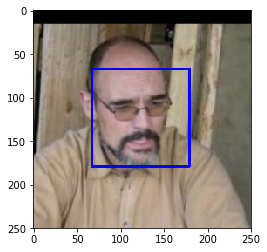

In [119]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(project_path+'haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

###  Human Face Detector

In [120]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

In [121]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

human_count = 0 
dog_count =  0

for human, dog in zip(human_files_short, dog_files_short):
    
    if not face_detector(human):
        human_count += 1
        
    if not face_detector(dog):
        dog_count += 1
        
print(100 - human_count," % in human_files have a detected human face")
print(100 - dog_count," % in dog_files have a detected human face")

97  % in human_files have a detected human face
8  % in dog_files have a detected human face


---
<a id='step2'></a>
## Step 2: Detect Dogs


### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on the ImageNet dataset.

In [122]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model


In [123]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    VGG16.eval()
    
    img = Image.open(img_path)
    
    composed = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.ToTensor()])


    transformed_sample = composed(img).unsqueeze(0)
    
    transformed_sample.shape

    output = VGG16(transformed_sample)

    _, pred = torch.max(output, 1)
    
    return pred # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

Dog breed are dictionary keys between 151 and 268 (inclusive).

In [124]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    
    pred = VGG16_predict(img_path)
    
    if pred > 151 and pred < 268:
        return True
    
    else:
        return False

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [125]:
dog_detected_in_humans = 0
dog_detected_in_dogs = 0


for human_img, dog_img in zip(human_files_short,dog_files_short):
    
    if dog_detector(human):
        dog_detected_in_humans += 1 
    if dog_detector(dog):
        dog_detected_in_dogs += 1

print(dog_detected_in_humans)
print(dog_detected_in_dogs) 

0
89


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

**Goal**: test accuracy of at least 10%.  
**Challenges**:

* Even a human wuld have trouble distinguishing between a Brittany and a Welsh Springer Spaniel. 

* Dog breed pairs with minimal *Inter-class variation* (for instance, Curly-Coated Retrievers and American Water Spaniels).

* *Intra-class* variation, classify all of these different shades as the same breed (for instance recall that labradors come in yellow, chocolate, and black.)

Brittany | Welsh Springer Spaniel 
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">


Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">

Yellow Labrador | Black Labrador | Chocolate Labrador
--- | --- | ---
<img src="images/Labrador_retriever_06457.jpg" width="120">  | <img src="images/Labrador_retriever_06449.jpg" width="150">  | <img src="images/Labrador_retriever_06455.jpg" width="150">



***

In [12]:
from torchvision import datasets

batch_size = 20

traindir = project_path+'dogImages/train'
valdir = project_path+'dogImages/valid'
testdir = project_path+'dogImages/test'

normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(traindir, transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(degrees=(0,15),translate=(0,0.07),scale=(0.8,1.2)),
        transforms.ColorJitter(brightness=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
        ])),
        batch_size = batch_size, shuffle=True,num_workers=0, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,])),
        batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


test_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(testdir, transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize,])),
        batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

loaders_scratch = {'train':train_loader, 'valid':val_loader, 'test': test_loader}

### Visualize augmented images
To visualize the effect of different preprocessing techniques on the images,  
the show_images() function takes a dataloader and displays some random images

In [21]:
import random

def show_images(data_loader, num_images=10):
    
    fig,ax = plt.subplots(2,5,figsize=(12,6))
    
    imgs, labels = iter(data_loader).next()
    
    
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            
            #one random sample image from batch
            rnd = random.randint(1,batch_size-1)
            img = imgs[rnd]

            #from [3,256,256] to [256,256,3] for display
            img = np.array(img).transpose((1, 2, 0))
            
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            img = std * img + mean
            
            ax[i,j].imshow(img)
    return

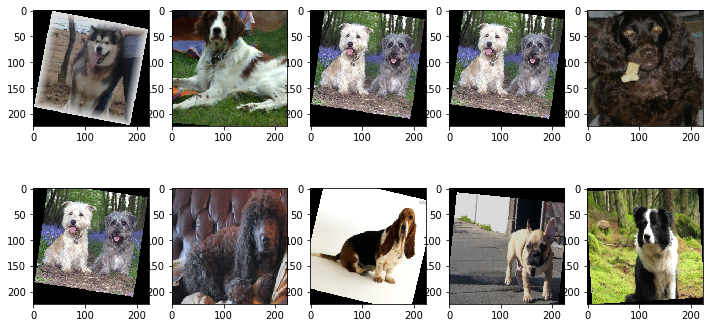

In [22]:
show_images(train_loader)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?   
**Answer**: I resized the images to a size of (224, 224). I tried different approaches like center cropping oder random cropping, but resizing yielded the best result.


- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?  
**Answer**: I used Random affine transformations (rotation, translation and scale). In addition I changed the brightness of the images and used random horizontal flips. I tried to choose ranges of augmentation that are reasonable of true perspective changes in real pictures. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [23]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv_bn1 = nn.BatchNorm2d(16)
        self.conv_bn2 = nn.BatchNorm2d(32)
        self.conv_bn3 = nn.BatchNorm2d(64)
        self.conv_bn4 = nn.BatchNorm2d(128)
        self.conv_bn5 = nn.BatchNorm2d(256)
        
        self.dropout1 = nn.Dropout(0.2)
       # self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(256*7*7,133)
        
    
    def forward(self, x):
        
        ## Define forward behavior
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_bn1(x)
        
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_bn2(x)
        
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv_bn3(x)
        
        x = self.pool(F.relu(self.conv4(x)))
        x = self.conv_bn4(x)
        
        x = self.pool(F.relu(self.conv5(x)))
        x = self.conv_bn5(x)
       
        #flattened layer shape [batch_size, features]
        x = x.view(-1,256*7*7)
        
        x = self.dropout1(x)
        
        x = self.fc1(x)
        
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  
__Answer:__ I started with a 3 layer CNN and did not see improvement on the validation loss. In consequence I tried a 4 and 5 layer CNN, too captrue more complex data patterns, and got the best result with the 5 layer CNN. I also used dropout to reduce overfitting. I tried different dropout values (0.1, 0.2, 0.5) and stayed with 0.2. Since Batch normalization is recommended in several articles I read, I implemented after each convolutional layer.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

In [24]:
import torch.optim as optim

### loss function
criterion_scratch = nn.CrossEntropyLoss()

### optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters())

### (IMPLEMENTATION) Train and Validate the Model


In [25]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [18]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                     
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                
            output = model(data)
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [22]:
# train the model
model_scratch = train(15, loaders_scratch, model_scratch, optimizer_scratch, 
                              criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 5.738071 	Validation Loss: 5.195864
Validation loss decreased (inf --> 5.195864).  Saving model ...
Epoch: 2 	Training Loss: 4.554476 	Validation Loss: 4.262596
Validation loss decreased (5.195864 --> 4.262596).  Saving model ...
Epoch: 3 	Training Loss: 3.822304 	Validation Loss: 4.164293
Validation loss decreased (4.262596 --> 4.164293).  Saving model ...
Epoch: 4 	Training Loss: 3.379433 	Validation Loss: 3.900900
Validation loss decreased (4.164293 --> 3.900900).  Saving model ...
Epoch: 5 	Training Loss: 2.986142 	Validation Loss: 3.789802
Validation loss decreased (3.900900 --> 3.789802).  Saving model ...
Epoch: 6 	Training Loss: 2.646006 	Validation Loss: 3.876266
Epoch: 7 	Training Loss: 2.299608 	Validation Loss: 3.886453
Epoch: 8 	Training Loss: 2.044075 	Validation Loss: 3.950529
Epoch: 9 	Training Loss: 1.777633 	Validation Loss: 4.047695
Epoch: 10 	Training Loss: 1.541406 	Validation Loss: 4.090965
Epoch: 11 	Training Loss: 1.363652 	Validation Lo

In [29]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model


In [30]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.721697


Test Accuracy: 17% (150/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

**Goal:** At least 60% accuracy on the test set. 

In [27]:
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Model Architecture

In [31]:
import torchvision.models as models
import torchvision

model_transfer = models.resnet18(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(512, 133, bias=True)

fc_parameters = model_transfer.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True

if use_cuda:
    model_transfer = model_transfer.cuda()

In [32]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ Resnet18 was the first choice and it performed well on the dataset. The only adjustment I did was the replacement of the output layer. I tried training for different number of epochs and tried adam and SGD as optimizers. The Resnet18 architecture is a complex network, trained on millions of Images. I searched for a rather cmplex architecture, because my experience with the model from scratch was that a simple CNN performs bad on the dog breed data.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

In [33]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [31]:
# train the model
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.178267 	Validation Loss: 3.192845
Validation loss decreased (inf --> 3.192845).  Saving model ...
Epoch: 2 	Training Loss: 2.854973 	Validation Loss: 2.224020
Validation loss decreased (3.192845 --> 2.224020).  Saving model ...
Epoch: 3 	Training Loss: 2.148998 	Validation Loss: 1.738526
Validation loss decreased (2.224020 --> 1.738526).  Saving model ...
Epoch: 4 	Training Loss: 1.768895 	Validation Loss: 1.456223
Validation loss decreased (1.738526 --> 1.456223).  Saving model ...
Epoch: 5 	Training Loss: 1.525587 	Validation Loss: 1.291013
Validation loss decreased (1.456223 --> 1.291013).  Saving model ...
Epoch: 6 	Training Loss: 1.349284 	Validation Loss: 1.185203
Validation loss decreased (1.291013 --> 1.185203).  Saving model ...
Epoch: 7 	Training Loss: 1.213497 	Validation Loss: 1.068260
Validation loss decreased (1.185203 --> 1.068260).  Saving model ...
Epoch: 8 	Training Loss: 1.129733 	Validation Loss: 1.022152
Validation loss decreased (1.06826

In [34]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [35]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.956848


Test Accuracy: 74% (619/836)


In [38]:
#create a dictionary with the different dog breeds
dog_files = np.array(glob("dogImages/train/*"))

classes = []
names = []

for i, path in enumerate(dog_files):
    base = os.path.basename(dog_files[i])
    classes.append(base)

classes.sort()

for item in classes:
    idx, name = item.split(".")
    names.append(name)
       
keys = np.arange(0,133)

dog_breeds = dict(zip(keys, names))

In [39]:
dog_breeds

{0: 'Affenpinscher',
 1: 'Afghan_hound',
 2: 'Airedale_terrier',
 3: 'Akita',
 4: 'Alaskan_malamute',
 5: 'American_eskimo_dog',
 6: 'American_foxhound',
 7: 'American_staffordshire_terrier',
 8: 'American_water_spaniel',
 9: 'Anatolian_shepherd_dog',
 10: 'Australian_cattle_dog',
 11: 'Australian_shepherd',
 12: 'Australian_terrier',
 13: 'Basenji',
 14: 'Basset_hound',
 15: 'Beagle',
 16: 'Bearded_collie',
 17: 'Beauceron',
 18: 'Bedlington_terrier',
 19: 'Belgian_malinois',
 20: 'Belgian_sheepdog',
 21: 'Belgian_tervuren',
 22: 'Bernese_mountain_dog',
 23: 'Bichon_frise',
 24: 'Black_and_tan_coonhound',
 25: 'Black_russian_terrier',
 26: 'Bloodhound',
 27: 'Bluetick_coonhound',
 28: 'Border_collie',
 29: 'Border_terrier',
 30: 'Borzoi',
 31: 'Boston_terrier',
 32: 'Bouvier_des_flandres',
 33: 'Boxer',
 34: 'Boykin_spaniel',
 35: 'Briard',
 36: 'Brittany',
 37: 'Brussels_griffon',
 38: 'Bull_terrier',
 39: 'Bulldog',
 40: 'Bullmastiff',
 41: 'Cairn_terrier',
 42: 'Canaan_dog',
 43: '

### (IMPLEMENTATION) Predict Dog Breed with the Model


In [46]:
import matplotlib.image as mpimg

#Given an image return dog breed

def predict_breed_transfer(img_path):
    
    #load and preprocess the image
    img = Image.open(img_path) 
    preprocess = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),normalize,])
    input_img = preprocess(img).unsqueeze(0)
    
    #make prediction
    output = model_transfer(input_img)
    _, pred = torch.max(output, 1)
    
    #determine associated dog breed
    class_pred = dog_breeds[int(pred.cpu())]
    
    return class_pred

In [50]:
#example_path = glob("dogImages/test/*/*")[15]
#exmp_img = Image.open(example_path)
#plt.imshow(exmp_img)

#predict_breed_transfer(example_path)

---
<a id='step5'></a>
## Step 5: Write Algorithm

Algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

### (IMPLEMENTATION) Write your Algorithm

In [98]:
def run_app(img_path):
    
    fig = plt.figure()
    img = Image.open(img_path)
    
    if face_detector(img_path):
        breed_pred = predict_breed_transfer(img_path)
        fig.text(0,0,'It is a Human and looks like a: '+ breed_pred,fontsize=20)
    
    elif dog_detector(img_path):
        breed_pred = predict_breed_transfer(img_path)
        fig.text(0,0,'It is a Dog from the breed: '+ breed_pred,fontsize=20)
    
    else:
        print('Error: neither dog or human detected')
    
    plt.axis('off')

    plt.imshow(img)
    
    return

<a id='step6'></a>
## Step 6: Test Algorithm on sample Images  



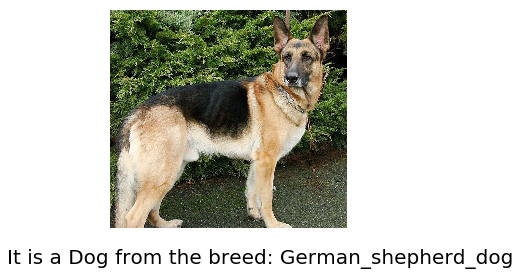

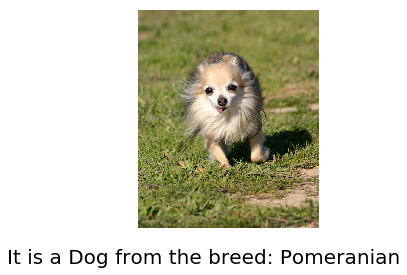

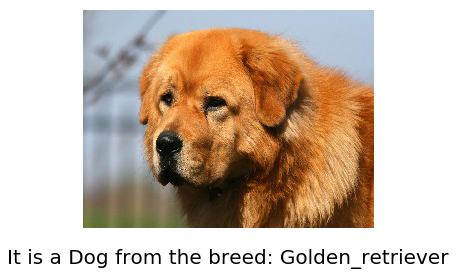

In [105]:
German_shepherd = "examples/German_shepherd_dog.jpg"
Chihuhua = "examples/Chihuahua.jpg"
Tibetan_mastiff = "examples/Tibetan_mastiff.jpg"
lion = "examples/lion.jpeg"
me = "examples/me.jpg"
trump = "examples/trump"

run_app(German_shepherd)
run_app(Chihuhua)
run_app(Tibetan_mastiff)

Error: neither dog or human detected


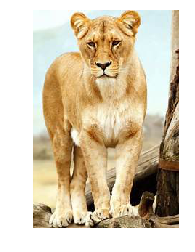

In [109]:
run_app(lion)

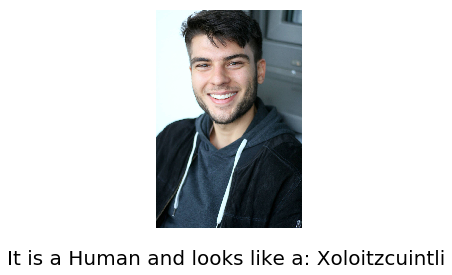

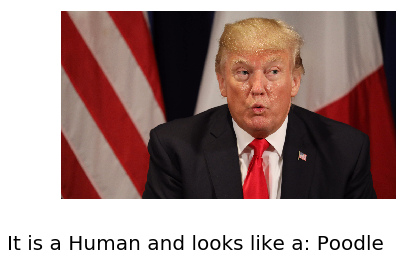

In [110]:
run_app(me)
run_app(trump)

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.  
__Answer:__ The discrimination of human and dogs works pretty good. The algorithm recognizes wheter it is a dog or a human. The classification of the dog breed is not too bad, the transfer model achieved 74% accuracy on the test set. And on the most missclassifications the predicted breed looks similiar to the actual breed.  
Possible improvements:
* Deep Learning Face detection
* Use different augmentation techniques like random cropping
* Avoid overfitting with higher dropout rates, aybe then training for more epochs yields better results